Loan default prediction - binary classification

* Libraries, data preparation
* Random Forest - Hyperparameters, Grid-search
* GBM - Hyperparameters, Grid-search
* Stacked Ensembles
* Comparing Models
* Conclusion


####For this project I specifically focus less on feature engineering and use a small dataset. The main purpose is to build supervised machine learning models with h2o and experiment with hyperparameters.

In [1]:
import numpy as np
import datetime
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

####Load the data and create train and test dataset

In [2]:
data = pd.read_csv("loandefault.csv")

####I will create a month variable from AP005 (date) column and I will drop AP005 column


In [3]:
data['AP005']= pd.to_datetime(data['AP005']) 

In [4]:
data['month'] = data['AP005'].dt.month

####I will drop the following variables

In [5]:
data = data.drop(columns=['id', 'Unnamed: 0', 'Unnamed: 0.1', 'AP005', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
                          'TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'CR012']) #'TD048', 'TD055', 'TD062', 'TD044', 'TD051', 'TD061', 'TD054',

####Binning the age column

In [6]:
data['AP001'] = pd.cut(x=data['AP001'],  bins=[19, 24, 29, 34, 39, 44, 49, 54, 59])

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     data, test_size=0.40, random_state=8)
train.shape

(48000, 73)

####Assign the index, columns, source and count variable in each source

In [8]:
var = pd.DataFrame(train.dtypes)
var = pd.DataFrame(train.dtypes).reset_index()
var.columns = ['varname','dtype'] 
var['source'] = var['varname'].str[:2]
#var.head()
var['source'].value_counts()

CD    36
TD    12
AP     8
CR     7
PA     6
MB     2
lo     1
mo     1
Name: source, dtype: int64

####Create the list of variables

In [9]:
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[var['source']=='AP']['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP004', 'AP006', 'AP007', 'AP008', 'AP009']

In [10]:
train['loan_default'].value_counts(dropna=False)

0    38661
1     9339
Name: loan_default, dtype: int64

###Initialize H2O

In [11]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,4 days 23 hours 59 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_natab_bcm2mk
H2O cluster total nodes:,1
H2O cluster free memory:,2.528 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [12]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

####I will create train and test sample and convert it into h2o dataframe

In [13]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)
#train_hex.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


####Identify response and predictor variables

In [14]:
target='loan_default'
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 
#predictors = newlist

####I am trying to predit a binary classification problem, so I need response variable to be a factor

In [15]:
train_hex['loan_default'] = train_hex['loan_default'].asfactor()
test_hex['loan_default'] = test_hex['loan_default'].asfactor()

####RANDOM FOREST - is an ensemble learning method, composed of multiple decision trees. By averaging out the impact of several decision trees, random forests tend to improve prediction.

####I will train base random forest model  WITH default settings FIRST, the goal of our initial model is to provide a baseline AUC that I will try later to beat with Hyperparameter tunning. The default number of trees in an H2O Random Forest is 50, usually increasing the trees in random forest increase the performance.

In [16]:
nfolds = 5

In [17]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        nfolds=nfolds,
        seed=8)
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [418]:
#rf_v1.confusion_matrix()
#rf_v1.auc() 

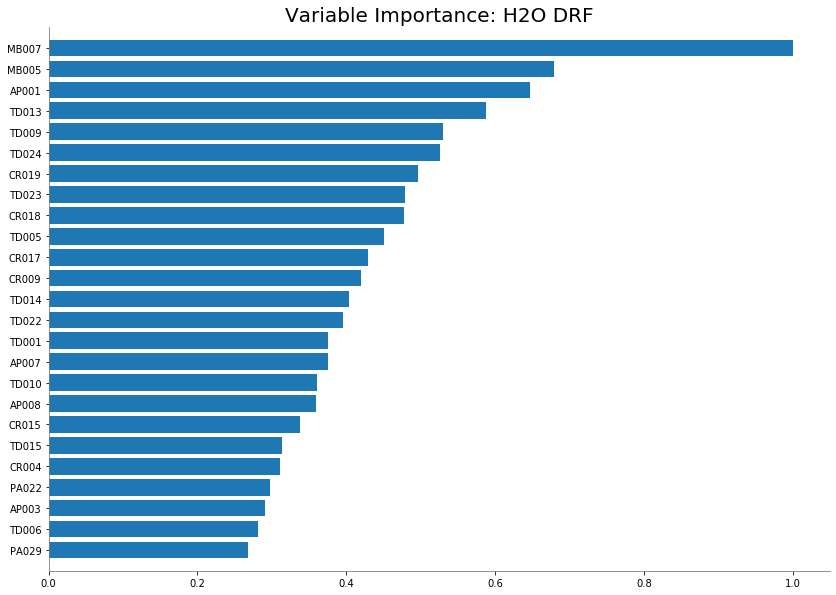

In [19]:
rf_v1.varimp_plot(num_of_features=25)

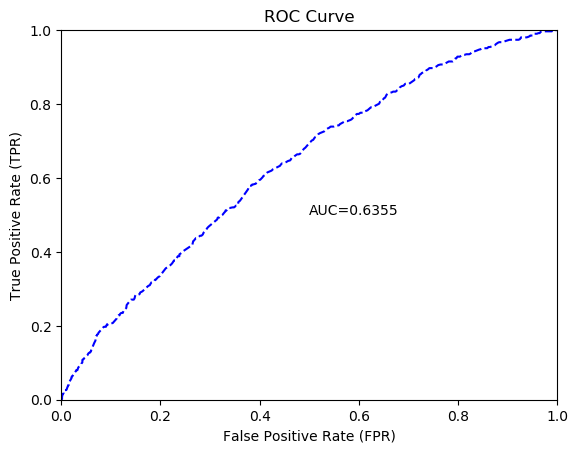

In [479]:
rf_v1.test = rf_v1.model_performance(test_hex)
rf_v1.test.plot()

####To get the best performance l want to tune at least some of these hyperparameters to maximize the predictive performance of  model. I would love to do full grid of hyperparameters, but I found that this could take a very substantial time to run in practice. I decided to focus on on most important hyperparameters: n_estimators, max_features, and max_depth.

####We can try out hyperparameter sets by hand - (manual search) - individually train a number of models with different combinations of values, and then to compare the model performance to choose the best model or we can use the Grid search - it builds models for every combination of hyperparameter values that we specify.


####adjusting the following set of hyperparameters:

- ntrees = number of trees in the foreset
- max_depth = max number of levels in each decision tree
- min_rows = the minimum number of observations for a leaf 
- mtries = the columns to randomly select at each level.

I will first create the Random Hyperparameter Grid
On each iteration, the algorithm will choose a difference combination of the features.

###GRID SEARCH

In [324]:
import h2o.grid

g = h2o.grid.H2OGridSearch(
  h2o.estimators.H2ORandomForestEstimator(
    nfolds=5
    ),
  hyper_params={
    "ntrees": [200, 800],
    "max_depth": [40, 60],
    "min_rows": [80, 100, 200],
      "mtries": [2, 8, 10]
    }
  )
#g.train(target, predictors, train)

In [36]:
g.train(predictors, target, train_hex)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


####by default, display the grid search results sorted by increasing logloss (we can change this parameter and sort it by auc)

In [37]:
g 

     max_depth min_rows mtries ntrees  \
0           40     80.0     10    800   
1           60     80.0     10    200   
2           40     80.0     10    200   
3           60     80.0     10    800   
4           60    100.0      8    200   
5           40    100.0     10    800   
6           40     80.0      8    200   
7           40     80.0      8    800   
8           60     80.0      8    800   
9           40    100.0      8    800   
10          40    100.0     10    200   
11          60    100.0     10    800   
12          60     80.0      8    200   
13          60    100.0     10    200   
14          60    100.0      8    800   
15          60    200.0     10    800   
16          40    100.0      8    200   
17          60    200.0     10    200   
18          40    200.0     10    200   
19          40    200.0     10    800   
20          60    200.0      8    200   
21          40    200.0      8    200   
22          60    200.0      8    800   
23          40  

####It has ordered from best to worst, we want logloss to be low. My results are: ‘max_depth’ = 40; ‘min_rows’ = ‘80’; ‘mtries’: 10 and 'ntrees' : 800, Now I WILL plug these back into the model to see if it improved  performance.

In [480]:
rf_tunned = H2ORandomForestEstimator(
        model_id = 'rf_tunned',
        ntrees = 800,
        min_rows=80,
        max_depth=40,
        nfolds = nfolds,
        fold_assignment = "Modulo",
        keep_cross_validation_predictions = True,
        seed=8)
rf_tunned.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [422]:
#rf_tunned.auc()

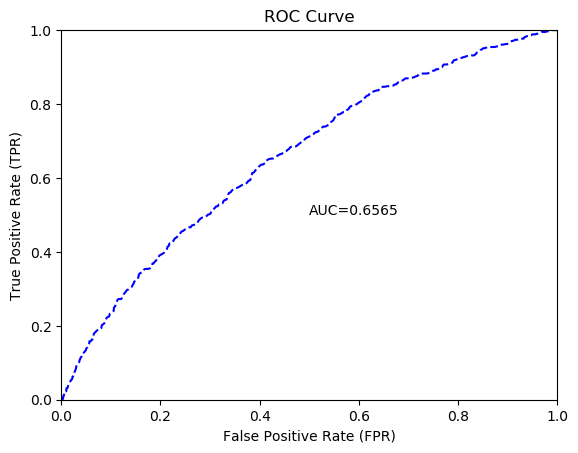

In [481]:
rf_tunned.test = rf_tunned.model_performance(test_hex)
rf_tunned.test.plot()

####The auc for our rf base model on train set was 63.55, after the tunning it improved 0.6565. the Grater the AUC the better is the performance of our model. 

####GBM h2o’s GBM sequentially builds regression trees on all the features of the dataset in a fully distributed way - each tree is built in parallel. First I will build a base model

In [498]:
gbm_v1 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v1',
        nfolds = nfolds,
        fold_assignment = "Modulo",
        keep_cross_validation_predictions = True,
        seed=8)
gbm_v1.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


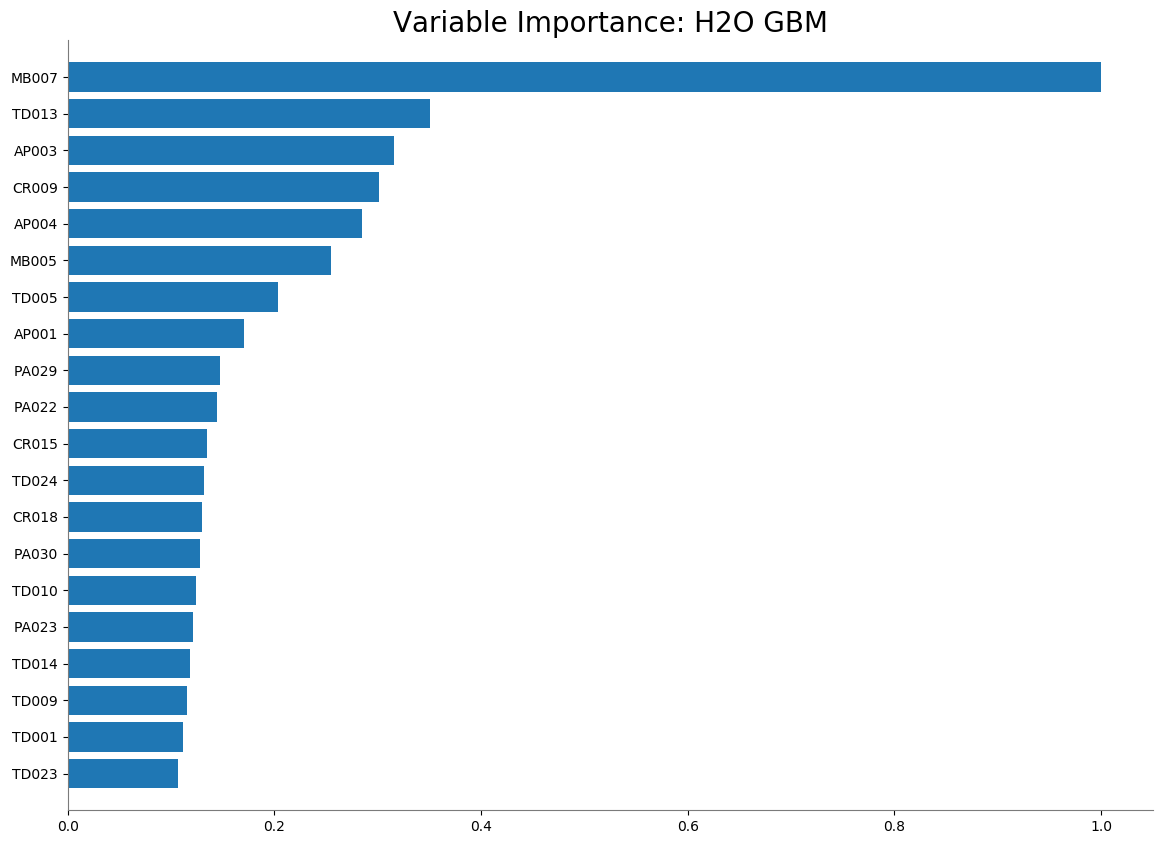

In [517]:
gbm_v1.varimp_plot(num_of_features=20)

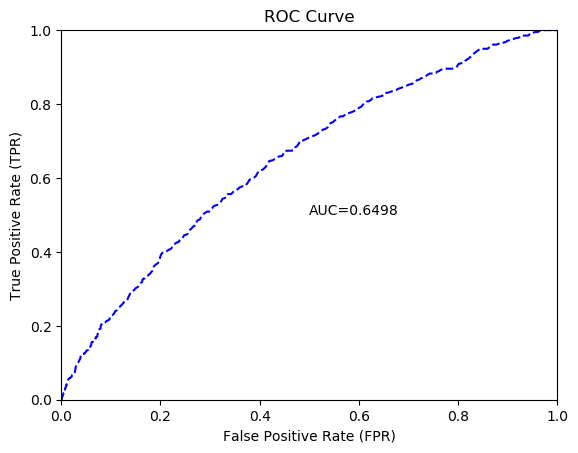

In [500]:
gbm_v1.test = gbm_v1.model_performance(test_hex)
gbm_v1.test.plot()

In [54]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

In [425]:
#Hyperparameters
gbm_params1 = {'learn_rate': [0.001, 0.01],
               'ntrees' : [10, 20, 50, 100, 500],
                'max_depth': [3, 5, 9],
                #'sample_rate': [0.4, 0.8, 1.0],
                #'col_sample_rate': [0.2, 0.5, 1.0],
               'min_rows' : [50, 100, 200]
                }

In [426]:
#Grid search
gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x=predictors, y=target,
                training_frame=train_hex,
                validation_frame=test_hex,
                ntrees = 1000,
                seed=8)

#grid results, sorted by validation AUC
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)
gbm_gridperf1


gbm Grid Build progress: |████████████████████████████████████████████████| 100%
       col_sample_rate learn_rate max_depth sample_rate            model_ids  \
0                  0.5       0.01         3         0.8   gbm_grid1_model_38   
1                  0.2       0.01         3         0.8   gbm_grid1_model_37   
2                  0.2       0.01         3         1.0   gbm_grid1_model_55   
3                  0.5       0.01         3         1.0   gbm_grid1_model_56   
4                  1.0        0.1         3         0.8    gbm_grid1_model_6   
5                  1.0       0.01         3         0.8   gbm_grid1_model_39   
6                  0.2        0.1         3         1.0   gbm_grid1_model_22   
7                  0.5       0.01         5         0.8    gbm_grid1_model_8   
8                  0.5       0.01         5         0.8   gbm_grid1_model_44   
9                  0.2       0.01         5         0.8   gbm_grid1_model_43   
10                 0.2        0.1      

####Now i will use the hyperparameters from grid search

In [482]:
gbm_tunned = H2OGradientBoostingEstimator(
        model_id = 'gbm_tunned',
        col_sample_rate = 0.5,
        learn_rate = 0.01,
        sample_rate = 0.8,
        min_rows = 200,
        max_depth= 5,
        ntrees = 1000,
        nfolds = nfolds,
        fold_assignment = "Modulo",
        keep_cross_validation_predictions = True,
        seed=8)
gbm_tunned.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


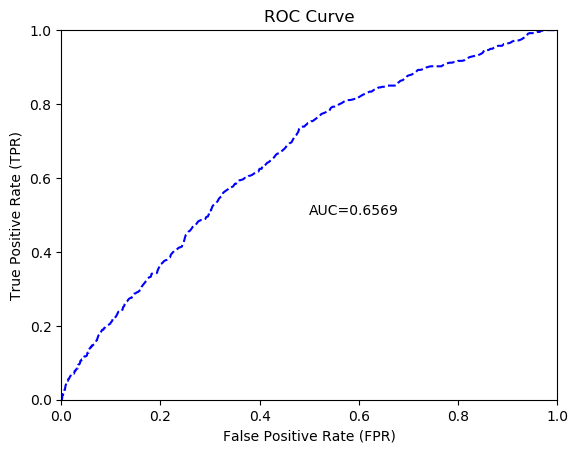

In [501]:
gbm_tunned.test = gbm_tunned.model_performance(test_hex)
gbm_tunned.test.plot()

####After tunning GBM model auc slightly increased from 0.6498 to 0.6569

####Stacked Ensambles - Ensemble machine learning methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms. I will use our best performed (tunned) GBM and RF models

In [502]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

In [503]:
nfolds = 5

In [504]:
models = [gbm_tunned.model_id, rf_tunned.model_id]

In [505]:
m_SE = H2OStackedEnsembleEstimator(model_id="SE_glm_rf",
                                  base_models = models)

In [506]:
m_SE.train(predictors, target, train_hex)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


####Stacked Ensamble

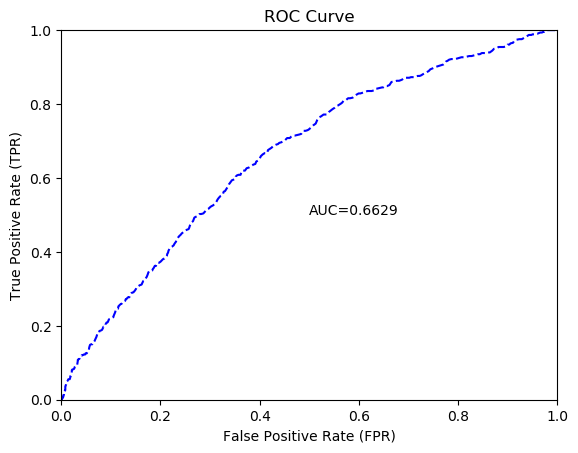

In [507]:
m_SE.test = m_SE.model_performance(test_hex)
m_SE.test.plot()

In [508]:
import pandas as pd

In [509]:
all_models = [gbm_tunned, rf_tunned, m_SE]

In [510]:
names = ["GBM", "RF", "SE"]

####Check performance of these models on test set

In [511]:
test_perf = list(map(lambda x: x.model_performance(test_hex), all_models))

###Logloss for GBM, RF, SE

In [512]:
pd.Series(map(lambda p: p.logloss(), test_perf), names)

GBM    0.466709
RF     0.469079
SE     0.465213
dtype: float64

####Ensemble model gives slighltly better results compared to gbm and rf models individually with lower logloss value

###AUC for GBM, RF, SE

In [513]:
pd.Series(map(lambda p: p.auc(), test_perf), names)

GBM    0.656902
RF     0.656512
SE     0.662925
dtype: float64

####Again Ensemble model gives slighltly better results compared to both models individually, it has higher AUC  values,  AUC =  0.662925

In [530]:
rf_tunned.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21197437442158915: 


,,0,1,Error,Rate
0,0,2283.0,1515.0,0.3989,(1515.0/3798.0)
1,1,389.0,613.0,0.3882,(389.0/1002.0)
2,Total,2672.0,2128.0,0.3967,(1904.0/4800.0)


In [531]:
gbm_tunned.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23927467285579945: 


,,0,1,Error,Rate
0,0,2869.0,929.0,0.2446,(929.0/3798.0)
1,1,334.0,668.0,0.3333,(334.0/1002.0)
2,Total,3203.0,1597.0,0.2631,(1263.0/4800.0)


In [532]:
m_SE.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23138219885026245: 


,,0,1,Error,Rate
0,0,2926.0,872.0,0.2296,(872.0/3798.0)
1,1,385.0,617.0,0.3842,(385.0/1002.0)
2,Total,3311.0,1489.0,0.2619,(1257.0/4800.0)


In [518]:
predictions = rf_tunned.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
#test_scores.head()

drf prediction progress: |████████████████████████████████████████████████| 100%


In [519]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()
    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains
    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(rf_tunned)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,80,240,320,80,240,0.13,0.09,61.3,1.31,4.0,25.00
1,320,89,231,640,169,471,0.28,0.18,122.6,1.38,10.0,26.41
2,320,86,234,960,255,705,0.42,0.27,183.9,1.39,15.0,26.56
3,320,75,245,1280,330,950,0.54,0.37,245.2,1.35,17.0,25.78
4,320,81,239,1600,411,1189,0.67,0.46,306.5,1.34,21.0,25.69
5,320,39,281,1920,450,1470,0.73,0.57,367.8,1.22,16.0,23.44
6,320,30,290,2240,480,1760,0.78,0.68,429.1,1.12,10.0,21.43
7,320,45,275,2560,525,2035,0.86,0.79,490.4,1.07,7.0,20.51
8,320,44,276,2880,569,2311,0.93,0.89,551.7,1.03,4.0,19.76


In [487]:
createGains(gbm_tunned)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,80,240,320,80,240,0.13,0.09,61.3,1.31,4.0,25.00
1,320,93,227,640,173,467,0.28,0.18,122.6,1.41,10.0,27.03
2,320,102,218,960,275,685,0.45,0.26,183.9,1.50,19.0,28.65
3,320,54,266,1280,329,951,0.54,0.37,245.2,1.34,17.0,25.70
4,320,45,275,1600,374,1226,0.61,0.47,306.5,1.22,14.0,23.38
5,320,51,269,1920,425,1495,0.69,0.58,367.8,1.16,11.0,22.14
6,320,51,269,2240,476,1764,0.78,0.68,429.1,1.11,10.0,21.25
7,320,44,276,2560,520,2040,0.85,0.79,490.4,1.06,6.0,20.31
8,320,44,276,2880,564,2316,0.92,0.90,551.7,1.02,2.0,19.58


In [489]:
createGains(m_SE)

stackedensemble prediction progress: |████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,89,231,320,89,231,0.15,0.09,61.3,1.45,6.0,27.81
1,320,80,240,640,169,471,0.28,0.18,122.6,1.38,10.0,26.41
2,320,89,231,960,258,702,0.42,0.27,183.9,1.40,15.0,26.88
3,320,74,246,1280,332,948,0.54,0.37,245.2,1.35,17.0,25.94
4,320,75,245,1600,407,1193,0.66,0.46,306.5,1.33,20.0,25.44
5,320,72,248,1920,479,1441,0.78,0.56,367.8,1.30,22.0,24.95
6,320,33,287,2240,512,1728,0.84,0.67,429.1,1.19,17.0,22.86
7,320,37,283,2560,549,2011,0.90,0.78,490.4,1.12,12.0,21.45
8,320,32,288,2880,581,2299,0.95,0.89,551.7,1.05,6.0,20.17


As expected by averaging out some noise from different models, stacked Ensemble model performed better than base or tunned RF and GBM models. with AUC score of 0.6629, to farther improve the model I would work more on feature engineering.

Thank you!